# Replicate the CERES model

## The CERES model

The following is the CERES model as desicrbed in ["Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells"](https://www.nature.com/articles/ng.3984#Sec24) (Meyeres *et al*, 2017).


$
\quad D_{ij} = q_i \lgroup \sum_{k \in G_i} (h_k + g_{kj}) + \mathcal{f} (\sum_{l \in L_i} C_{lj}) \rgroup + o_i + \epsilon
$

where:

- $D_{ij}$: sgRNA $i$ depletion in cell line $j$
- $q_i$: "guide activity score... to mitigate the influence of low-quality reagents" (restricted $[0,1]$)
- $G_i$: the genes targeted by sgRNA $i$
- $h_k$: "shared" (non-cell-line-specific) effect of gene $k$
- $g_{kj}$: cell-line-specific effect in cell line $j$ and gene $k$
- $\mathcal{f}_j$: piecewise linear spine to model copy number effect
- $L_i$: target loci of sgRNA $i$
- $C_{lj}$: copy number of target locus $l$ in cell line $j$
- $o_i$: sgRNA-sepcific effect to account for noise in the measurement of sgRNA abundance in the reference pool
- $\epsilon$: normal error

In [8]:
import string
import warnings
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

### Data preparation

In [9]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

# print(data.hugo_symbol.unique())
# SAMPLED_GENES = ["KRAS", "BRAF", "DPH7", "KIF3C", "SCMH1", "UQCRC1"]
# SAMPLED_DEPMAPIDS = data["depmap_id"].unique()
# SAMPLED_DEPMAPIDS = np.random.choice(SAMPLED_DEPMAPIDS, 70, replace=False)

# data = data[~np.isnan(data.segment_mean)]
# data = data[data["hugo_symbol"].isin(SAMPLED_GENES)]
# data = data[data["depmap_id"].isin(SAMPLED_DEPMAPIDS)]

data.head(n=5)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730


In [10]:
print(f"testing with {data.shape[0]} data points")

testing with 60049 data points


In [11]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into categorical."""
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=ordered)
    return df


cat_cols = [
    "sgrna",
    "replicate_id",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
    "chromosome",
]

for col in cat_cols:
    data = make_cat(data, col)

In [12]:
def count_unique(df, col):
    """Count the number of unique values in a column."""
    return len(df[col].unique())


def get_indices(df, col):
    """Get a list of the indices for a column."""
    return df[col].cat.codes.to_list()


num_sgrnas = count_unique(data, "sgrna")
num_genes = count_unique(data, "hugo_symbol")
num_cell_lines = count_unique(data, "depmap_id")

sgrna_idx = get_indices(data, "sgrna")
gene_idx = get_indices(data, "hugo_symbol")
cell_line_idx = get_indices(data, "depmap_id")

In [13]:
data["gene_cn_z"] = data["gene_cn"].apply(lambda x: np.min((x, 10)))
data["gene_cn_z"] = data.groupby("hugo_symbol")["gene_cn_z"].apply(
    lambda x: (x - np.mean(x)) / np.std(x)
)

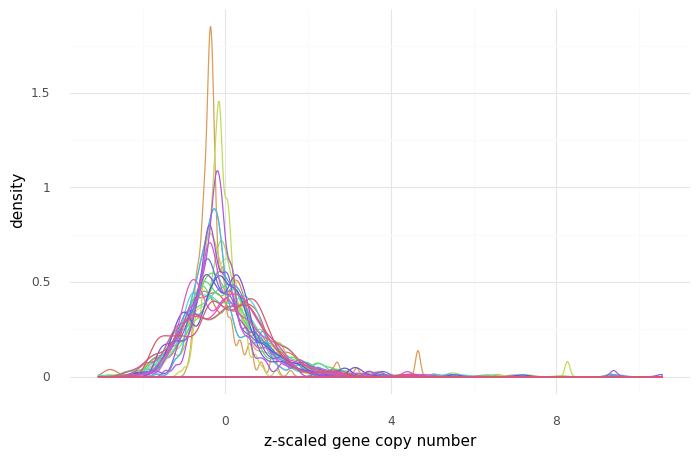

<ggplot: (8748564365743)>

In [15]:
(
    gg.ggplot(data, gg.aes(x="gene_cn_z"))
    + gg.geom_density(gg.aes(color="hugo_symbol"), size=0.5)
    + gg.scale_color_discrete(guide=False)
    + gg.theme(figure_size=(8, 5))
    + gg.labs(x="z-scaled gene copy number", y="density")
)

### To-Do

- experiment with splines in PyMC3
    - on their own
    - with other covariates
- make an even smaller data set with 5 genes and 5 cell lines for developing the models (next)
- make the models:
    - model without copy number
    - model with copy number as normal covariate
    - model with copy number using a spline

In [16]:
raise Exception("TODODODODODOD")

Exception: TODODODODODOD

### Model 1.

Below is the model that will be fit with PyMC3 as the mimic of CERES.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} \beta_{ij} C_{ij} \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad \beta_{ij} \sim \mathcal{N}(-0.2, 0.5) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [34]:
with pm.Model() as ceres_m1:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 1, shape=(num_genes, num_cell_lines))
    #     beta_ij = pm.Normal("beta_ij", -0.2, 0.5, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = (
        q_i[sgrna_idx] * (h_k[gene_idx] + g_kj[gene_idx, cell_line_idx])
        + o_i[sgrna_idx]
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


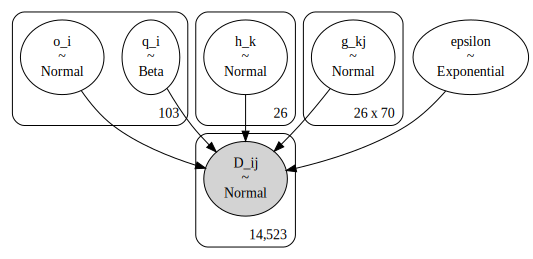

In [35]:
pm.model_to_graphviz(ceres_m1)

In [37]:
%%time

ceres_m1_cachedir = pymc3_cache_dir / "ceres_m1"

ceres_m1_samples = pmhelp.pymc3_sampling_procedure(
    model=ceres_m1,
    num_mcmc=2000,
    tune=1000,
    chains=2,
    prior_check_samples=1000,
    ppc_samples=1000,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m1_cachedir,
    force=False,
)

Loading cached trace and posterior sample...
CPU times: user 592 ms, sys: 315 ms, total: 906 ms
Wall time: 917 ms


In [38]:
az_ceres_m1 = az.from_pymc3(
    trace=ceres_m1_samples["trace"],
    model=ceres_m1,
    prior=ceres_m1_samples["prior_predictive"],
    posterior_predictive=ceres_m1_samples["posterior_predictive"],
)

arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


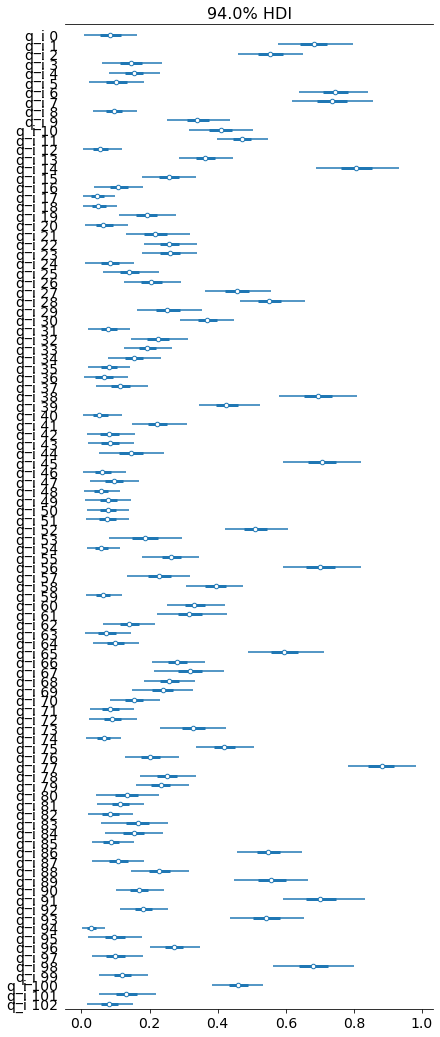

In [39]:
az.plot_forest(az_ceres_m1, var_names="q_i", combined=True)
plt.show()

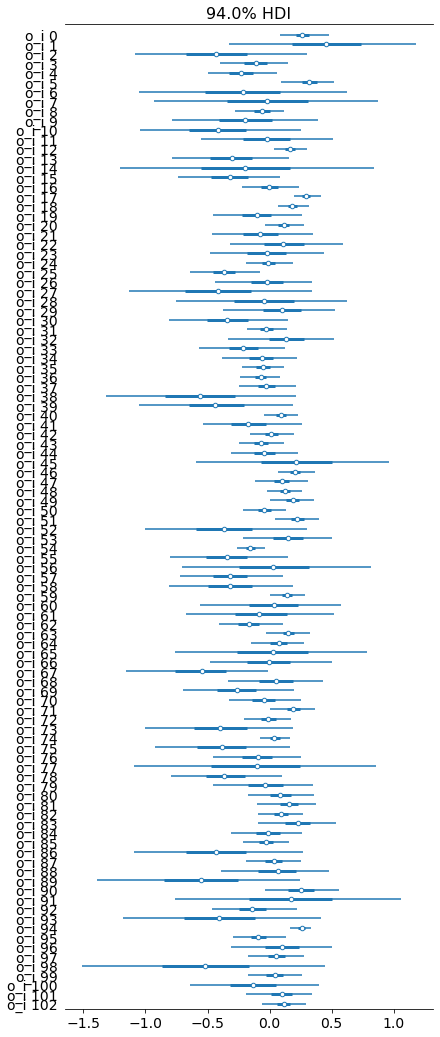

In [40]:
az.plot_forest(az_ceres_m1, var_names="o_i", combined=True)
plt.show()

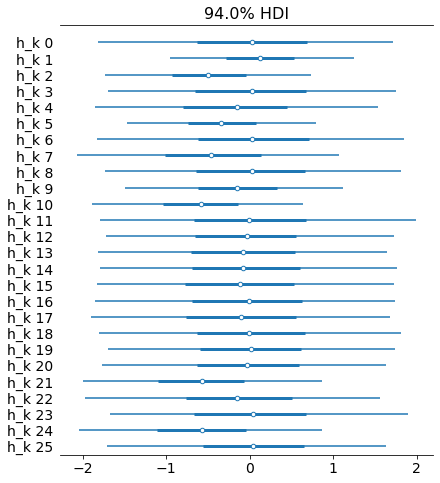

In [41]:
az.plot_forest(az_ceres_m1, var_names="h_k", combined=True)
plt.show()

In [42]:
gene_effect_post = ceres_m1_samples["trace"].get_values("g_kj")
gene_effect_post.shape

(4000, 26, 70)

In [43]:
gene_effect_mean = gene_effect_post.mean(axis=0)
gene_effect_mean.shape

(26, 70)

In [44]:
data["hugo_symbol"].cat.categories

Index(['PDE5A', 'TP53', 'KRAS', 'KIF3C', 'ZSWIM8', 'MDM2', 'HIST1H2BO',
       'NDUFAF3', 'DISP1', 'BRAF', 'PTK2', 'IQCK', 'LGALS7B', 'CXCL2',
       'LGALS4', 'ADAMTS13', 'SLC7A14', 'DPH7', 'RNF125', 'GHSR', 'SCMH1',
       'PIK3CA', 'PHACTR3', 'FAM43B', 'UQCRC1', 'SMAD7'],
      dtype='object')

In [49]:
gene_effect_post_df = (
    pd.DataFrame(gene_effect_mean)
    .reset_index()
    .rename(columns={"index": "gene_idx"})
    .melt(id_vars="gene_idx", var_name="cell_line_idx", value_name="gene_effect")
    .assign(
        hugo_symbol=lambda d: [
            data["hugo_symbol"].values.categories[i] for i in d["gene_idx"].values
        ],
        depmap_id=lambda d: [
            data["depmap_id"].values.categories[i] for i in d["cell_line_idx"].values
        ],
    )
)

cols = ["depmap_id", "kras_mutation", "is_deleterious"]
mutation_info = data[cols].drop_duplicates()
mutation_info[cols[:-1]] = mutation_info[cols[:-1]].astype("str")

gene_effect_post_df = gene_effect_post_df.merge(
    mutation_info, how="left", on=["depmap_id"]
)

gene_effect_post_df.head(n=10)

,gene_idx,cell_line_idx,gene_effect,hugo_symbol,depmap_id,kras_mutation,is_deleterious
0,0,0,1.040254,PDE5A,ACH-000011,WT,NaN
1,0,0,1.040254,PDE5A,ACH-000011,WT,FALSE
2,1,0,3.376785,TP53,ACH-000011,WT,NaN
3,1,0,3.376785,TP53,ACH-000011,WT,FALSE
4,2,0,0.974897,KRAS,ACH-000011,WT,NaN
5,2,0,0.974897,KRAS,ACH-000011,WT,FALSE
6,3,0,-0.649296,KIF3C,ACH-000011,WT,NaN
7,3,0,-0.649296,KIF3C,ACH-000011,WT,FALSE
8,4,0,0.054926,ZSWIM8,ACH-000011,WT,NaN
9,4,0,0.054926,ZSWIM8,ACH-000011,WT,FALSE


In [50]:
data.is_deleterious.unique()

array([nan, 'FALSE', 'FALSE;FALSE', 'TRUE', 'FALSE;TRUE;FALSE',
       'FALSE;FALSE;FALSE', 'TRUE;FALSE', 'FALSE;TRUE'], dtype=object)

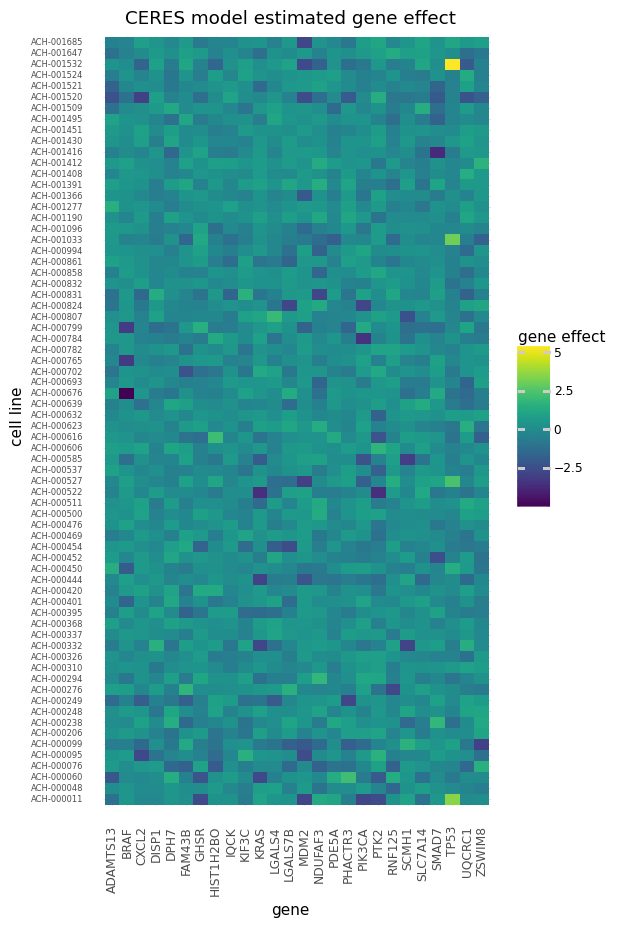

<ggplot: (8732273703665)>

In [51]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="gene_effect"))
    + gg.theme(
        figure_size=(5, 10),
        axis_text_x=gg.element_text(angle=90),
        axis_text_y=gg.element_text(size=6),
    )
    + gg.labs(
        x="gene",
        y="cell line",
        fill="gene effect",
        title="CERES model estimated gene effect",
    )
)

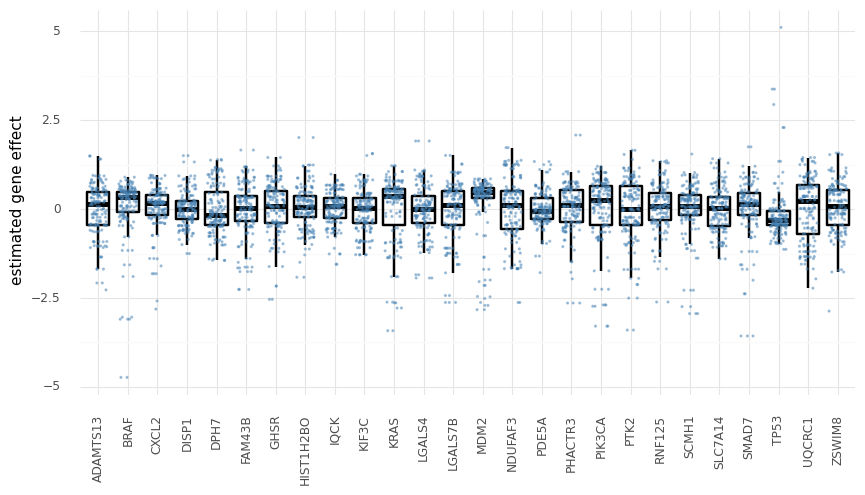

<ggplot: (8732273699615)>

In [52]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0, size=1)
    + gg.geom_jitter(alpha=0.4, size=0.3, height=0, width=0.3, color="steelblue")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(10, 5)
    )
    + gg.labs(x=None, y="estimated gene effect")
)

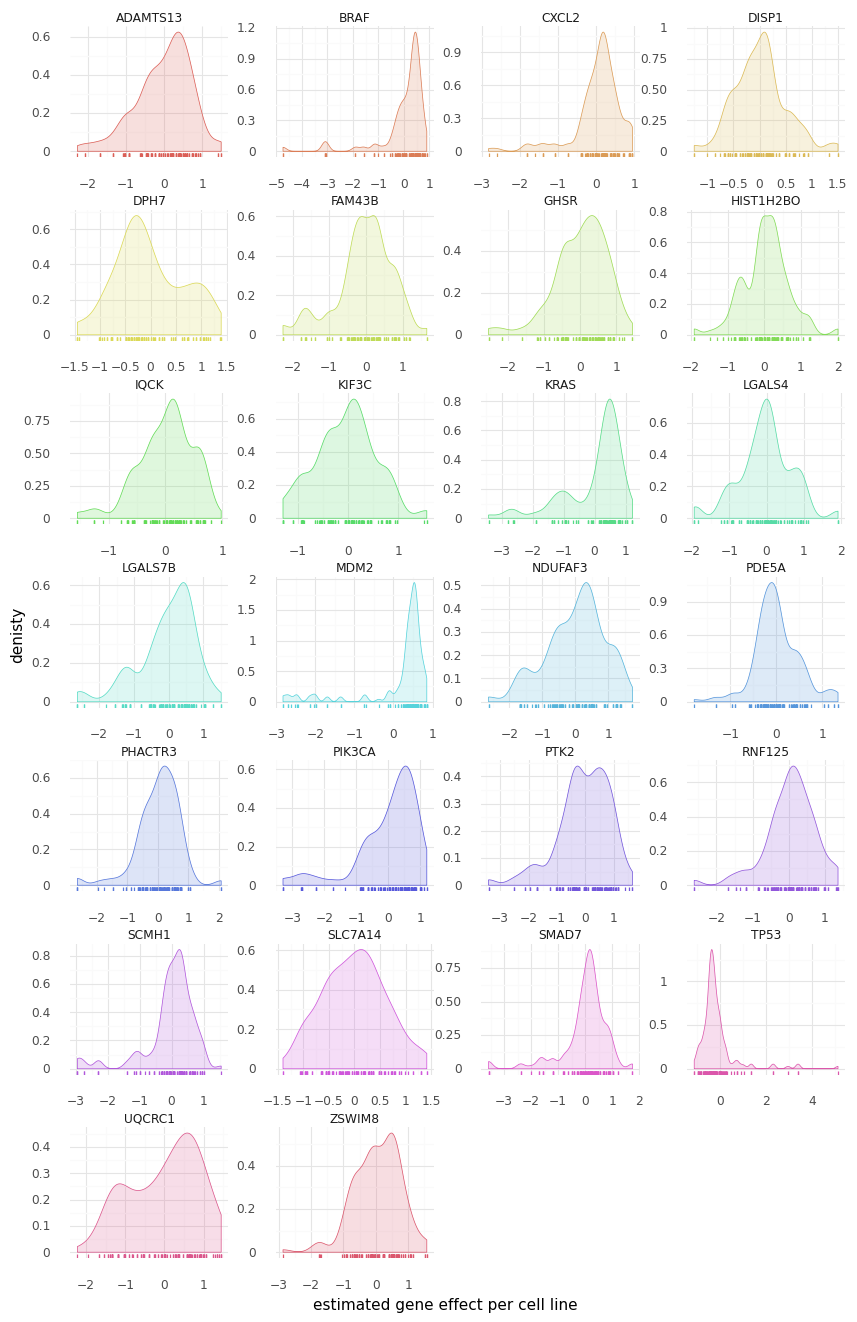

<ggplot: (8732273461836)>

In [53]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="gene_effect"))
    + gg.facet_wrap("hugo_symbol", ncol=4, scales="free")
    + gg.geom_density(
        gg.aes(color="hugo_symbol", fill="hugo_symbol"), alpha=0.2, size=0.3
    )
    + gg.geom_rug(gg.aes(color="hugo_symbol"))
    + gg.theme(
        figure_size=(10, 16),
        legend_position="none",
        subplots_adjust={"hspace": 0.4, "wspace": 0.3},
    )
    + gg.labs(x="estimated gene effect per cell line", y="denisty")
)

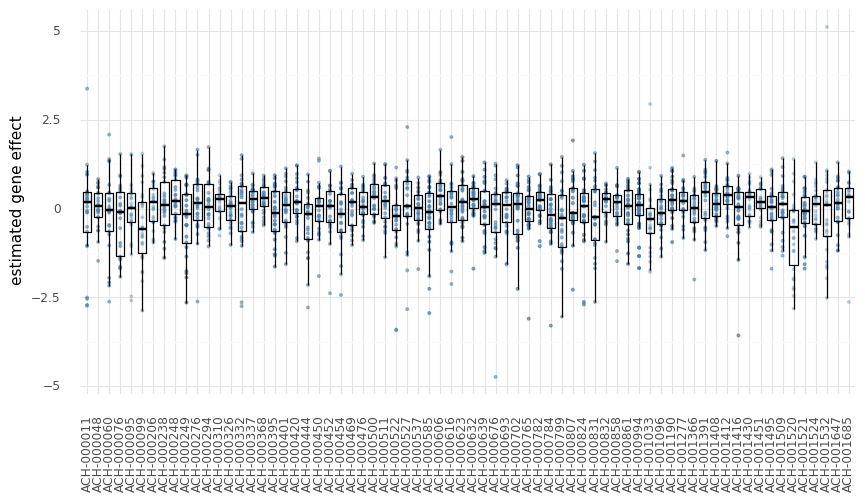

<ggplot: (8732275656304)>

In [54]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="depmap_id", y="gene_effect"))
    + gg.geom_jitter(alpha=0.3, size=0.6, height=0, width=0, color="steelblue")
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(10, 5)
    )
    + gg.labs(x=None, y="estimated gene effect")
)

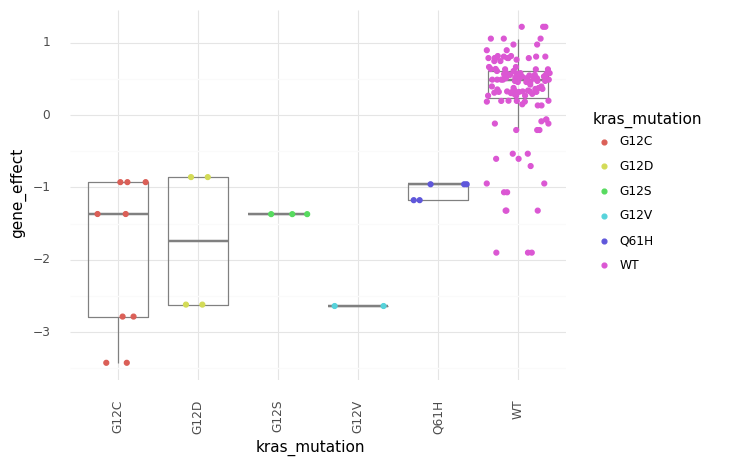

<ggplot: (8732273613972)>

In [55]:
kras_gene_effect = gene_effect_post_df[
    gene_effect_post_df.hugo_symbol == "KRAS"
].reset_index(drop=True)

(
    gg.ggplot(kras_gene_effect, gg.aes(x="kras_mutation", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="gray", outlier_alpha=0)
    + gg.geom_jitter(gg.aes(color="kras_mutation"), width=0.4, height=0)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
)